In [50]:
%cd /content/drive/MyDrive/Colab Notebooks/baocao_kpdl

/content/drive/MyDrive/Colab Notebooks/baocao_kpdl


In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
%pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
# Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import re, string
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [52]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/baocao_kpdl/SPAM text message 20170820 - Data.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [53]:
print(f'Checking missing values of the dataset:')

df.isnull().sum()

Checking missing values of the dataset:


Category    0
Message     0
dtype: int64

In [54]:
print(f'Checking duplicates from the dataset:')

df.duplicated().sum()

Checking duplicates from the dataset:


415

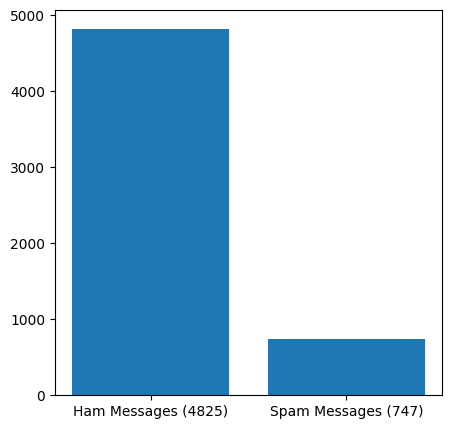

In [55]:
# Check the distribution of Ham/Spam messages
ham_count = int(df['Category'].loc[df['Category'] == 'ham'].count())
spam_count = int(df['Category'].loc[df['Category'] == 'spam'].count())
names = ['Ham Messages (' + str(ham_count) + ')', 'Spam Messages (' + str(spam_count) + ')']
counts = [ham_count, spam_count]
plt.figure(figsize=(5, 5))
plt.bar(names, counts)
plt.show()

In [56]:
# Tính độ dài trung bình của các thông điệp Ham và Spam
ham_message_length = []
spam_message_length = []
for i in df.values:
    if i[0] == "ham":
        ham_message_length.append(len(i[1]))
    else:
        spam_message_length.append(len(i[1]))

# Tính độ dài trung bình
ham_average = sum(ham_message_length) / len(ham_message_length)
spam_average = sum(spam_message_length) / len(spam_message_length)
print("ham_average: ", ham_average)
print("spam_average: ", spam_average)



ham_average:  71.44829015544042
spam_average:  137.9892904953146


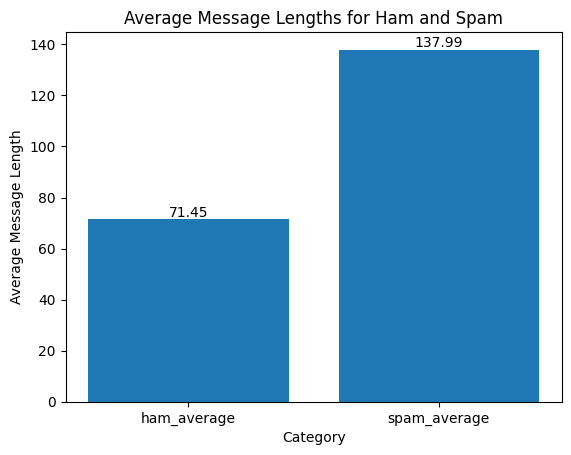

In [57]:
# Dữ liệu để vẽ biểu đồ cột
names = ['ham_average', 'spam_average']
lengths = [ham_average, spam_average]

# Tạo biểu đồ cột
fig, ax = plt.subplots()
rects = ax.bar(names, lengths)

# Hiển thị số liệu tương ứng bên trên các cột
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, str(round(height, 2)), ha='center', va='bottom')

# Thêm tiêu đề và nhãn trục của biểu đồ
ax.set_xlabel('Category')
ax.set_ylabel('Average Message Length')
ax.set_title('Average Message Lengths for Ham and Spam')

# Hiển thị biểu đồ
plt.show()


In [58]:
import re
import pandas as pd
import spacy
import unicodedata
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS

def remove_emails(text):
    """
    Loại bỏ email khỏi văn bản.
    """
    text = re.sub(r'\S+@\S+', '', text)
    return text

def remove_html_tags(text):
    """
    Loại bỏ các thẻ HTML khỏi văn bản.
    """
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    return text

def remove_stopwords(text):
    """
    Loại bỏ các từ dừng khỏi văn bản.
    """
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_stop:
            tokens.append(token.text)
    return ' '.join(tokens)

def make_base(text):
    """
    Chuyển đổi các từ trong văn bản thành dạng cơ bản.
    """
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token.lemma_)
    join_tokens = (' ').join(tokens)
    return join_tokens

def remove_special_chars(text):
    """
    Loại bỏ các ký tự đặc biệt khỏi văn bản.
    """
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text

def remove_accented_chars(text):
    """
    Loại bỏ các ký tự có dấu khỏi văn bản.
    """
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def text_preprocessing(df, col_name):
    """
    Áp dụng các bước xử lý dữ liệu văn bản cho cột được chỉ định trong DataFrame.
    """
    # Chuyển đổi tất cả các chữ cái trong tất cả các chuỗi thành chữ thường
    df[col_name] = df[col_name].apply(lambda x: x.lower())

    # Loại bỏ các ký tự đặc biệt
    df[col_name] = df[col_name].apply(lambda x: remove_special_chars(x))

    # Loại bỏ các ký tự có dấu
    df[col_name] = df[col_name].apply(lambda x: remove_accented_chars(x))

    # Loại bỏ các email
    df[col_name] = df[col_name].apply(lambda x: remove_emails(x))

    # Loại bỏ các thẻ HTML
    df[col_name] = df[col_name].apply(lambda x: remove_html_tags(x))

    # Loại bỏ các từ dừng
    df[col_name] = df[col_name].apply(lambda x: remove_stopwords(x))

    # Chuyển đổi các từ thành dạng cơ bản
    df[col_name] = df[col_name].apply(lambda x: make_base(x))

    # Trả về DataFrame đã được xử lý
    return df


In [59]:
cleaned_df = text_preprocessing(df, "Message")

In [60]:
### Calculating the word frequency by using nltk
import nltk
nltk.download('punkt')

words_list = []
for sentence in cleaned_df.Message:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('u', 1130),
 ('not', 622),
 ('m', 497),
 ('2', 482),
 ('ur', 390),
 ('s', 326),
 ('come', 324),
 ('go', 318),
 ('4', 293),
 ('know', 283),
 ('ok', 278),
 ('good', 278),
 ('ltgt', 276),
 ('free', 275),
 ('send', 273),
 ('get', 268),
 ('like', 254),
 ('want', 243),
 ('ill', 243),
 ('day', 242)]

In [61]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import plotly.express as px

# Create a DataFrame of the top 25 words
temp = pd.DataFrame(freq_dist.most_common(25), columns=['word', 'count'])

# Create a bar plot
fig = px.bar(temp, x='word', y='count', title='Top words')

# Rotate the x-ticks vertically
fig.update_layout(xaxis_tickangle=90)

# Show the plot
fig.show()


In [63]:
#Handling the duplicates
# Specify the columns to check for duplicates
columns_to_check = ['Category', 'Message']  # Replace with the actual column names

# Check for duplicate entries based on specified columns
duplicate_entries = cleaned_df[cleaned_df.duplicated(subset=columns_to_check, keep=False)]

# Print the duplicate entries
print(duplicate_entries)


     Category                                            Message
2        spam  free entry 2 wkly comp win fa cup final tkts 2...
7         ham  request melle melle oru minnaminunginte nurung...
8        spam  winner value network customer select receivea ...
9        spam  mobile 11 month u r entitle update late colour...
11       spam  chance win cash 100 20000 pound txt csh11 send...
...       ...                                                ...
5535      ham  know thinkin malaria relax child not handle ma...
5539      ham                                sleepingand surfing
5547     spam  contract mobile 11 mnth late motorola nokia et...
5553      ham                               hahahause brain dear
5558      ham                                    sorry ill later

[795 rows x 2 columns]


In [64]:
# Remove duplicates
df_no_duplicates = cleaned_df.drop_duplicates(inplace=True)

<Axes: >

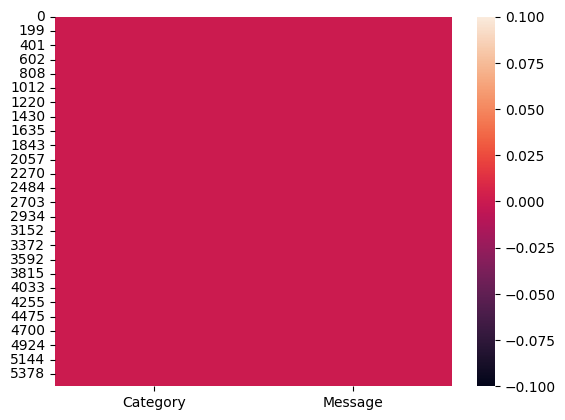

In [65]:
import seaborn as sns
sns.heatmap(df.isnull())

In [66]:
# Labeling target variable (prediction)
# Ham/Non-Spam messages = 0
# Spam messages = 1
df['Category'] = df['Category'].map({
    'ham' : 0,
    'spam' : 1
    })

In [67]:
# Text cleaning (remove punctuations and special characters)
def clean_text(message):
    text = message.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['Message'] = df['Message'].apply(lambda x: clean_text(x))
df


,Category,Message
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar joke wif u oni
2,1,free entry wkly comp win fa cup final tkts ...
3,0,u dun early hor u c
4,0,nah not think go usf life
...,...,...
5567,1,time try contact u u win pound prize claim...
5568,0,b go esplanade fr home
5569,0,pity mood soany suggestion
5570,0,guy bitching act like d interested buying week...


In [68]:
# Split dataset (train and test set)
x = df['Message']
y = df['Category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [69]:
# Vectorize the text into numerical form
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

Confusion Matrix:
 [[882  10]
 [ 52  76]]
Accuracy Score :  93.92 %
Precision Score :  88.37 %
Recall Score :  59.38 %
F1 Score :  71.03 %


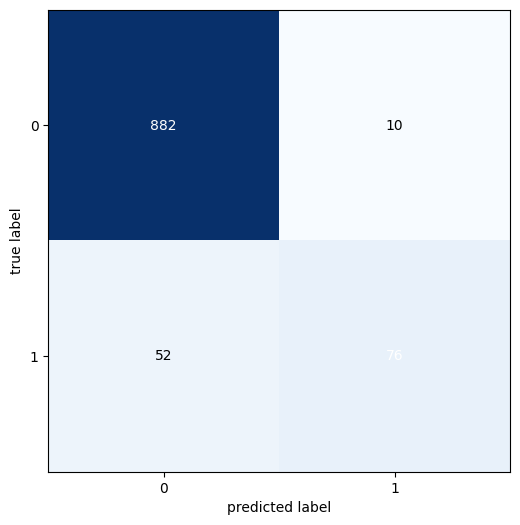

In [70]:
# DECISION TREE (GINI)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Training the model
model_dt_gini = DecisionTreeClassifier(criterion="gini", random_state=123, max_depth=10, min_samples_leaf=8)
model_dt_gini.fit(xv_train, y_train)

# Save the model
import pickle
with open('model_dt_gini.pkl', 'wb') as f:
    pickle.dump(model_dt_gini, f)

# Evaluating the model
y_pred_dtg = model_dt_gini.predict(xv_test)
model_dt_gini_accuracy = round(accuracy_score(y_test, y_pred_dtg) * 100, 2)
model_dt_gini_precision = round(precision_score(y_test, y_pred_dtg) * 100, 2)
model_dt_gini_recall = round(recall_score(y_test, y_pred_dtg) * 100, 2)
model_dt_gini_f1_score = round(f1_score(y_test, y_pred_dtg) * 100, 2)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_dtg)

# In ra các thông số đánh giá của mô hình
print("Confusion Matrix:\n", cm)
print("Accuracy Score : ", model_dt_gini_accuracy, "%")
print("Precision Score : ", model_dt_gini_precision, "%")
print("Recall Score : ", model_dt_gini_recall, "%")
print("F1 Score : ", model_dt_gini_f1_score, "%")

# Vẽ Confusion matrix dưới dạng heatmap
plot_confusion_matrix(conf_mat=cm, figsize=(6,6))
plt.show()

In [73]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

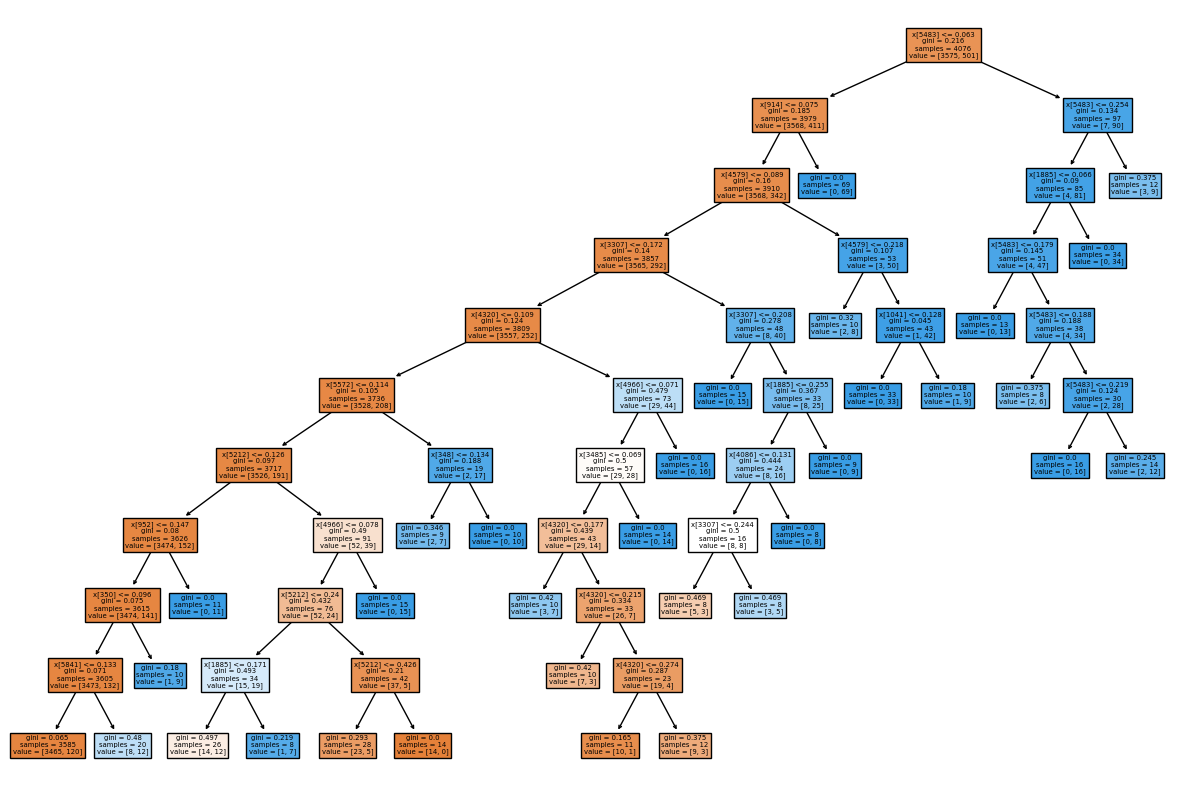

In [75]:

from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(15,10))
plot_tree(model_dt_gini, filled=True)
plt.show()

In [ ]:
#Sử dụng kỹ thuật oversampling SMOTE để tăng số lượng mẫu trong tập huấn luyện và tinh chỉnh các siêu tham số của cây quyết định bằng GridSearchCV để tìm ra bộ siêu tham số tốt nhất cho mô hình.
# Cuối cùng, chúng ta đánh giá mô hình trên tập kiểm tra và in ra các thông số đánh giá của mô hình.

Confusion Matrix:
 [[881  11]
 [ 56  72]]
Accuracy Score :  93.43 %
Precision Score :  86.75 %
Recall Score :  56.25 %
F1 Score :  68.25 %


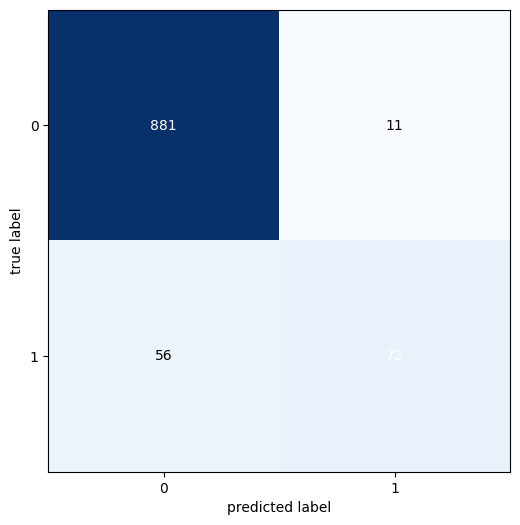

In [88]:
# DECISION TREE (ENTROPY)
# Model training

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

model_dt_entropy = DecisionTreeClassifier(criterion = "entropy", random_state=123, max_depth=10, min_samples_leaf=8)
model_dt_entropy.fit(xv_train, y_train)
#luu module
import pickle

with open('model_dt_entropy.pkl', 'wb') as f:
    pickle.dump(model_dt_entropy, f)



# Evaluating the model
y_pred_dte = model_dt_entropy.predict(xv_test)
model_dt_entropy_accuracy = round(accuracy_score(y_test,y_pred_dte) * 100, 2)
model_dt_entropy_precision = round(precision_score(y_test, y_pred_dte) * 100, 2)
model_dt_entropy_recall = round(recall_score(y_test,y_pred_dte) * 100, 2)
model_dt_entropy_f1_score = round(f1_score(y_test, y_pred_dte) * 100, 2)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_dte)

# In ra các thông số đánh giá của mô hình
print("Confusion Matrix:\n", cm)
print("Accuracy Score : ", model_dt_entropy_accuracy, "%")
print("Precision Score : ", model_dt_entropy_precision, "%")
print("Recall Score : ", model_dt_entropy_recall, "%")
print("F1 Score : ",model_dt_entropy_f1_score, "%")

# Vẽ Confusion matrix dưới dạng heatmap
plot_confusion_matrix(conf_mat=cm, figsize=(6,6))
plt.show()

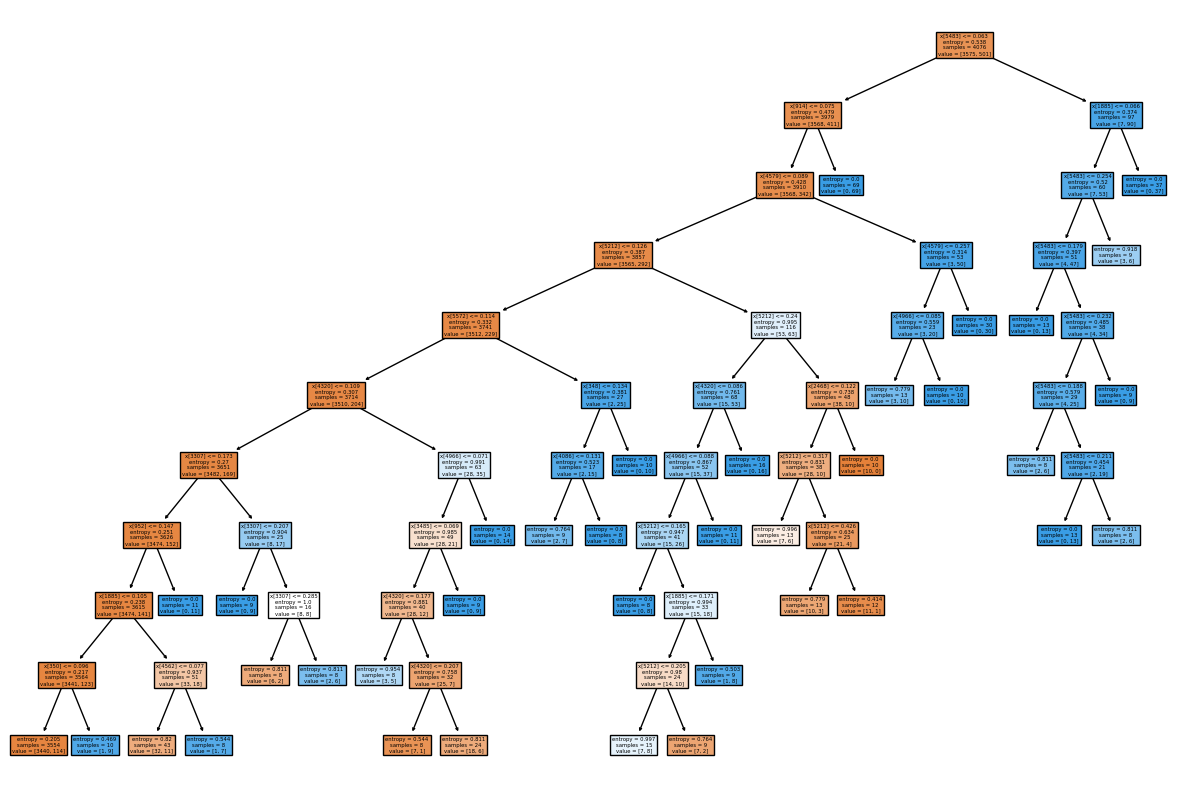

In [77]:

from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(15,10))
plot_tree(model_dt_entropy, filled=True)
plt.show()

Confusion Matrix:
 [[889   3]
 [ 39  89]]
Accuracy Score :  95.88 %
Precision Score :  96.74 %
Recall Score :  69.53 %
F1 Score :  80.91 %


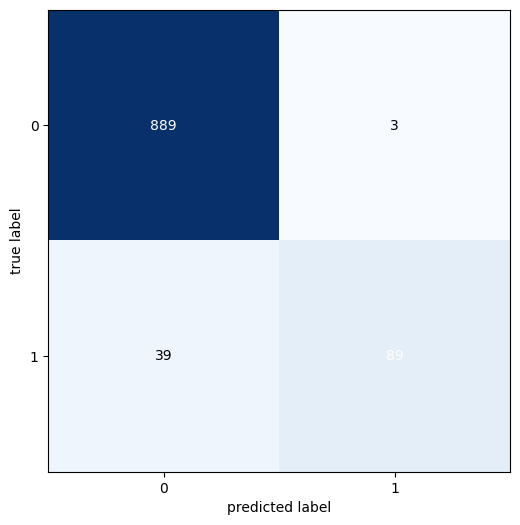

In [89]:
# LOGISTIC REGRESSION
# Model training
model_lr = LogisticRegression(random_state=0)
model_lr.fit(xv_train, y_train)
#luu module
import pickle

with open('model_lr.pkl', 'wb') as f:
    pickle.dump(model_lr, f)



# Evaluating the model
y_pred_lr = model_lr.predict(xv_test)
model_lr_accuracy = round(accuracy_score(y_test,y_pred_lr) * 100, 2)
model_lr_precision = round(precision_score(y_test, y_pred_lr) * 100, 2)
model_lr_recall = round(recall_score(y_test,y_pred_lr) * 100, 2)
model_lr_f1_score = round(f1_score(y_test, y_pred_lr) * 100, 2)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# In ra các thông số đánh giá của mô hình
print("Confusion Matrix:\n", cm)
print("Accuracy Score : ",model_lr_accuracy, "%")
print("Precision Score : ", model_lr_precision, "%")
print("Recall Score : ",model_lr_recall, "%")
print("F1 Score : ",model_lr_f1_score, "%")

# Vẽ Confusion matrix dưới dạng heatmap
plot_confusion_matrix(conf_mat=cm, figsize=(6,6))
plt.show()

Confusion Matrix:
 [[890   2]
 [ 32  96]]
Accuracy Score :  96.67 %
Precision Score :  97.96 %
Recall Score :  75.0 %
F1 Score :  84.96 %


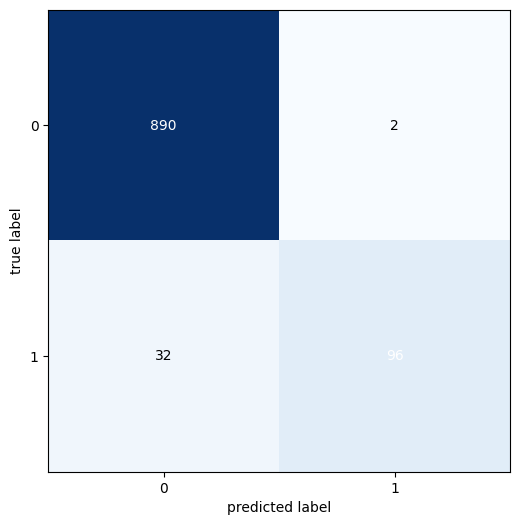

In [92]:
# RANDOM FOREST
# Model training
model_rf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)
model_rf.fit(xv_train, y_train)
import pickle

with open('model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)
# Evaluating the model
y_pred_rf  = model_rf.predict(xv_test)
model_rf_accuracy = round(accuracy_score(y_test,y_pred_rf ) * 100, 2)
model_rf_precision = round(precision_score(y_test, y_pred_rf ) * 100, 2)
model_rf_recall = round(recall_score(y_test,y_pred_rf ) * 100, 2)
model_rf_f1_score = round(f1_score(y_test, y_pred_rf ) * 100, 2)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf )

# In ra các thông số đánh giá của mô hình
print("Confusion Matrix:\n", cm)
print("Accuracy Score : ",model_rf_accuracy, "%")
print("Precision Score : ",model_rf_precision, "%")
print("Recall Score : ",model_rf_recall, "%")
print("F1 Score : ",model_rf_f1_score, "%")

# Vẽ Confusion matrix dưới dạng heatmap
plot_confusion_matrix(conf_mat=cm, figsize=(6,6))
plt.show()

In [80]:
#rích xuất cây quyết định đầu tiên trong mô hình RandomForestClassifier
rf_tree = model_rf.estimators_[0]

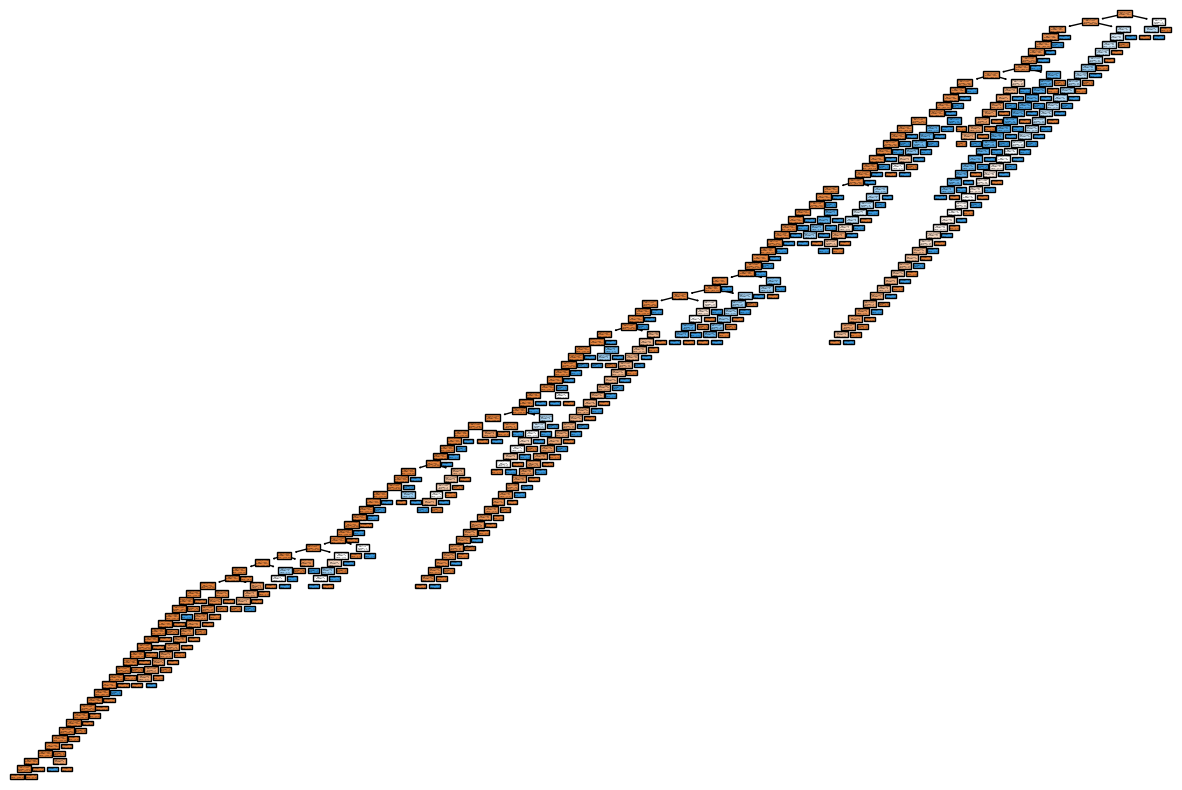

In [81]:
plt.figure(figsize=(15,10))
plot_tree(rf_tree, filled=True)
plt.show()

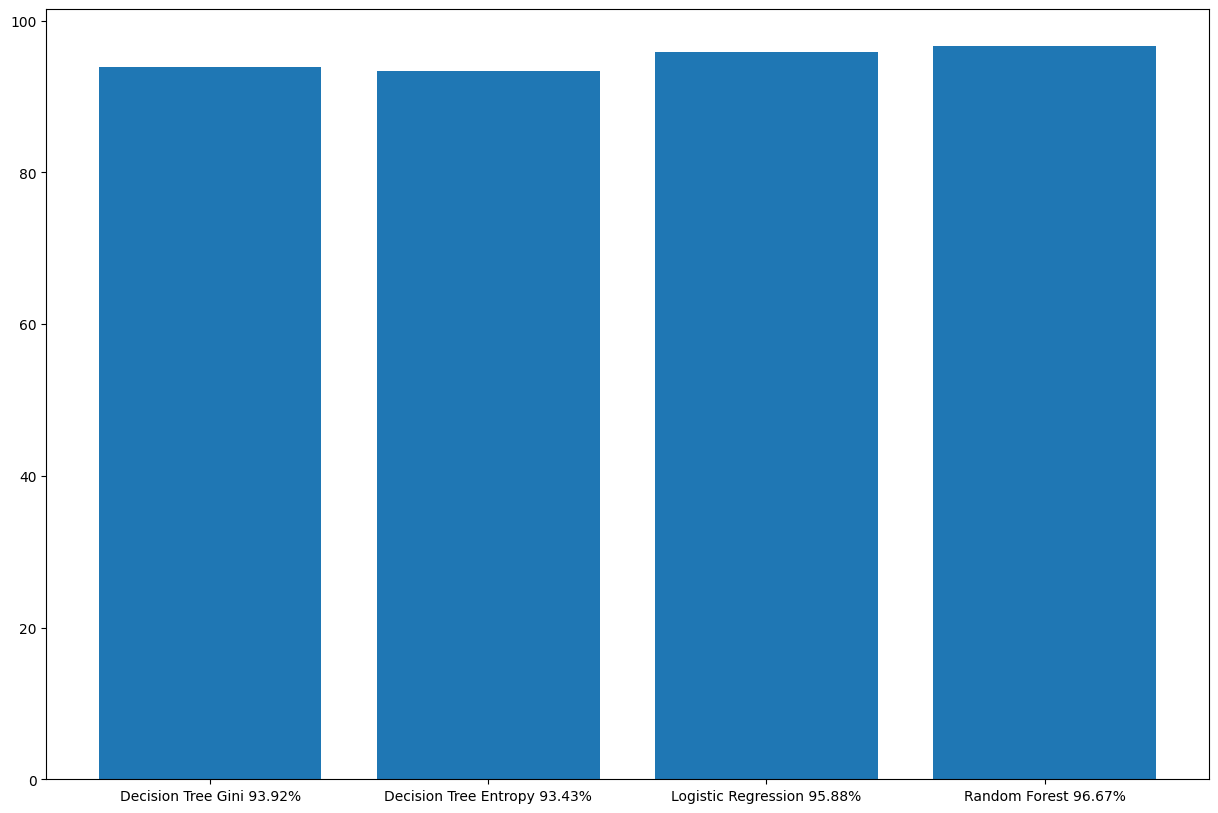

In [82]:
# Model Comparison
model_names = ['Decision Tree Gini ' + str(model_dt_gini_accuracy) + '%',
               'Decision Tree Entropy ' + str(model_dt_entropy_accuracy) + '%',
               'Logistic Regression ' + str(model_lr_accuracy) + '%', 'Random Forest ' + str(model_rf_accuracy) + '%']
model_accuracy = [model_dt_gini_accuracy, model_dt_entropy_accuracy, model_lr_accuracy, model_rf_accuracy]
plt.figure(figsize=(15, 10))
plt.bar(model_names, model_accuracy)
plt.show()

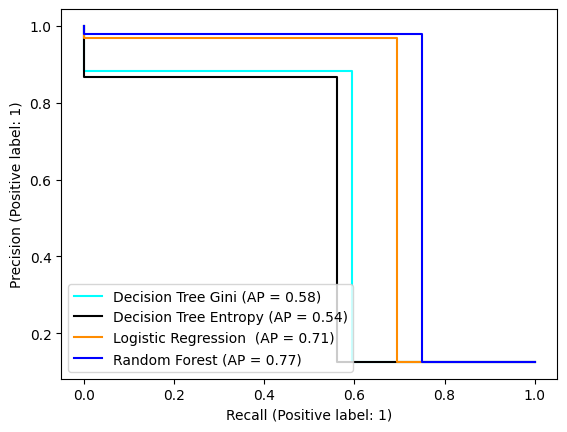

In [83]:
#Precision-Recall Curve
from sklearn.datasets import make_classification
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, y_pred_dtg, name=f"Decision Tree Gini", color="cyan", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, y_pred_dte, name=f"Decision Tree Entropy", color="black", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, y_pred_lr, name=f"Logistic Regression ", color="darkorange", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test,  y_pred_rf, name=f"Random Forest", color="blue", ax=ax)


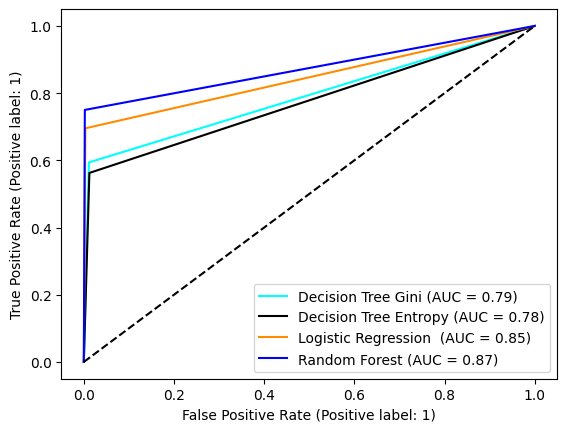

In [84]:
#ROC Curve

from sklearn.metrics import RocCurveDisplay


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_pred_dtg, name=f"Decision Tree Gini", color="cyan", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_pred_dte, name=f"Decision Tree Entropy", color="black", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_pred_lr, name=f"Logistic Regression ", color="darkorange", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_pred_rf, name=f"Random Forest", color="blue", ax=ax)

plt.plot([0, 1], [0, 1], color="black", linestyle="--")


In [95]:
# Predict new text
new_text ="As a valued customer, I am pleased to advise you that following recent review of your Mob No. you are awarded with a ?œ1500 Bonus Prize, call 09066364589"
# Vectorize the new text into numerical form
new_text_vector = vectorization.transform([new_text])
# Model prediction
model_dt_gini_pred = model_dt_gini.predict(new_text_vector)[0]
print('Decision Tree (Gini) model Prediction:')
print('Spam message' if model_dt_gini_pred==1 else 'non-spam message')
model_dt_entropy_pred = model_dt_entropy.predict(new_text_vector)[0]
print('Decision Tree (Entropy) model Prediction:')
print('Spam message' if model_dt_entropy_pred==1 else 'non-spam message')
model_lr_pred = model_lr.predict(new_text_vector)[0]
print('Logistic Regression Model Prediction:')
print('Spam message' if model_lr_pred==1 else 'non-spam message')
model_rf_pred = model_rf.predict(new_text_vector)[0]
print('Random Forest Model Prediction:')
print('Spam message' if model_rf_pred==1 else 'non-spam message')

Decision Tree (Gini) model Prediction:
non-spam message
Decision Tree (Entropy) model Prediction:
non-spam message
Logistic Regression Model Prediction:
non-spam message
Random Forest Model Prediction:
Spam message
